# Fake news detection
## BiLSTM with GloVe

In [ ]:
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Preprocessed_Train.csv')
df_val = pd.read_csv('/content/drive/MyDrive/Preprocessed_Valid.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Preprocessed_Test.csv')

df_test.head()

,Text,Label
0,The son Louisiana man whose father shot killed...,1
1,Copies William Shakespeare first four books du...,1
2,Debt 20 000 Source College credit cards Estima...,1
3,It late. I drunk nearing 35th birthday past Ma...,1
4,A central Texas man serving life sentence doub...,1


In [ ]:
texts=df['Text'].tolist()
y_train=np.array(df['Label'])

In [ ]:
texts_val=df_val['Text'].tolist()
y_val=np.array(df_val['Label'])

In [ ]:
texts_test=df_test['Text'].tolist()
y_test=np.array(df_test['Label'])

In [ ]:
# MAX_NB_WORDS = 100000 # max number of words for tokenizer
MAX_LEN = 4533 # max length of each sentences, including padding
# VALIDATION_SPLIT = 0.2 # 20% of data for validation (not used in training)
EMBEDDING_DIM = 200 # embedding dimensions for word vectors

In [ ]:
def get_word_ind(texts):
    tokenizer = Tokenizer(lower=True)
    tokenizer.fit_on_texts(texts)
    word_index = tokenizer.word_index
    print('Vocabulary size:', len(word_index))
    return word_index

In [ ]:
df_conc=pd.concat([df['Text'], df_val['Text'], df_test['Text']], ignore_index=True)
texts_conc=df_conc.tolist()
word_ind=get_word_ind(texts_conc)

Vocabulary size: 376743


In [ ]:
def tokenize(texts,MAX_LEN):
    tokenizer = Tokenizer(lower=True)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    # word_index = tokenizer.word_index
    # print('Vocabulary size:', len(word_index))
    data = pad_sequences(sequences, padding = 'post', maxlen = MAX_LEN)
    print('Shape of data tensor:', data.shape)
    return data

In [ ]:
x_train = tokenize(texts, MAX_LEN)
x_val = tokenize(texts_val, MAX_LEN)
x_test = tokenize(texts_test, MAX_LEN)

Shape of data tensor: (63616, 4533)
Shape of data tensor: (15905, 4533)
Shape of data tensor: (7011, 4533)


In [ ]:
embeddings_dict = {}
with open("/content/drive/MyDrive/glove.6B.200d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [ ]:
embedding_matrix = np.random.random((len(word_ind) + 1, EMBEDDING_DIM))
for word, i in word_ind.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Create LSTM model

model = Sequential()
# model.add(InputLayer(input_shape=(MAX_LEN,), dtype='int32'))
model.add(Embedding(len(word_ind) + 1,
          EMBEDDING_DIM,
          weights = [embedding_matrix],
          input_length = MAX_LEN,
          trainable=False,
          name = 'embeddings'))
# model.add(Bidirectional(LSTM(128,name='lstm_layer', return_sequences=True)))
# model.add(GlobalMaxPool1D())
# model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128,name='lstm_layer2')))
# model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs = 3, batch_size = 128, validation_data = (x_val, y_val), shuffle = True)

Epoch 1/3
497/497 [==============================] - 397s 795ms/step - loss: 0.4875 - accuracy: 0.7583 - val_loss: 0.6616 - val_accuracy: 0.6939
Epoch 2/3
497/497 [==============================] - 393s 792ms/step - loss: 0.2987 - accuracy: 0.8724 - val_loss: 0.7534 - val_accuracy: 0.6922
Epoch 3/3
497/497 [==============================] - 394s 793ms/step - loss: 0.1880 - accuracy: 0.9249 - val_loss: 0.6972 - val_accuracy: 0.6936


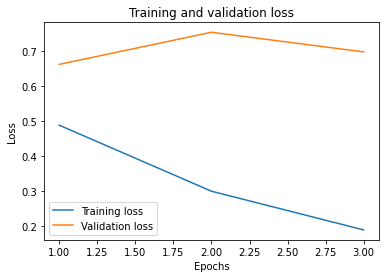

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

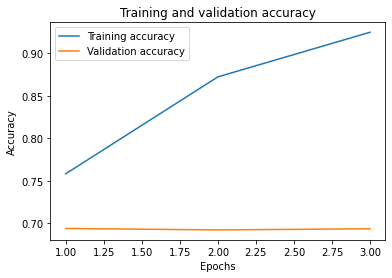

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [ ]:
pred = model.predict(x_test, batch_size=128)

In [ ]:
pred_labels = np.where(pred > 0.5, 1,0)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_test = y_test.flatten()
pred_labels = pred_labels.flatten()
pd.DataFrame(confusion_matrix(y_test,pred_labels))

,0,1
0,855,1387
1,862,3907


In [ ]:
print(classification_report(y_test,pred_labels))

              precision    recall  f1-score   support

           0       0.50      0.38      0.43      2242
           1       0.74      0.82      0.78      4769

    accuracy                           0.68      7011
   macro avg       0.62      0.60      0.60      7011
weighted avg       0.66      0.68      0.67      7011

